In [87]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
try:
    import google.colab
    IN_COLAB = True
    %pip install wandb
    %pip install --upgrade "kaleido==0.1.*"
    import kaleido
except:
    IN_COLAB = False
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import plotly.io as pio
import tempfile
from PIL import Image
import io
import wandb
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from enum import Enum
import plotly.express as px
import math

import dataclasses
from typing import Any, Dict, List, Optional, Tuple, Union
from dataclasses import dataclass

NUM_CLASSES = 10

class TempFileContext:
    def __enter__(self):
        self.tmp_file = tempfile.NamedTemporaryFile(suffix=".jpeg", delete=False)
        self.tmp_filename = self.tmp_file.name
        return self.tmp_filename
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.tmp_file.close()
        os.remove(self.tmp_filename)

# As per the DCGAN paper: All the weights are initialized from a zero centered normal distribution with standard deviation 0.02
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

class GeneratorUpSample(nn.Module):
    def __init__(self, channels_noise, channels_img, num_classes, features_g):
        """
        channels_noise: The size of the input noise vector. This noise vector is a random input from which the generator begins the generation of a new sample.
        channels_img: The number of output channels of the generator. This will typically be 1 for grayscale images or 3 for color (RGB) images.
        num_classes: The number of distinct classes or labels that the generator should generate images for. This is used to form the one-hot vector of class labels, which is concatenated to the noise vector to provide the generator with information about the class of image to generate.
        """
        # Conv2d formula => output_size = (input_size - 1) * stride - 2 * padding + kernel_size
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self.gen_block(channels_noise + num_classes, features_g * 4, kernel_size=7, stride=1, padding=0),  # output: (features_g*4) x 7 x 7 # Append class labels to input noise.
            nn.Dropout(p=0.05),
            self._block(features_g * 4, features_g * 2, kernel_size=4, stride=2, padding=1),  # output: (features_g*2) x 6 x 6
            nn.Upsample(scale_factor=4, mode='bilinear'),  # output: (features_g*2) x 14 x 14
            nn.Dropout(p=0.05),
            self._block(features_g * 2, features_g, kernel_size=4, stride=2, padding=1),  # output: features_g x 14 x 14
            nn.Upsample(scale_factor=5, mode='bilinear'),  # output: features_g x 28 x 28
            nn.Dropout(p=0.05),
            self._block(features_g, channels_img, kernel_size=7, stride=1, padding=2),  # output: channels_img x 28 x 28
            nn.Tanh(),  # normalize [-1, 1]
        )
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def gen_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    @autocast() # automatically applies precisions to different operations to speed up calculations
    def forward(self, noise):
        return self.gen(noise)

class GeneratorFractional(nn.Module):
    def __init__(self, channels_noise, channels_img, num_classes, features_g):
        """
        channels_noise: The size of the input noise vector. This noise vector is a random input from which the generator begins the generation of a new sample.
        channels_img: The number of output channels of the generator. This will typically be 1 for grayscale images or 3 for color (RGB) images.
        num_classes: The number of distinct classes or labels that the generator should generate images for. This is used to form the one-hot vector of class labels, which is concatenated to the noise vector to provide the generator with information about the class of image to generate.
        """
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(channels_noise + num_classes, features_g * 8, kernel_size=4, stride=2, padding=1),  # output: (features_g*8) x 2 x 2
            self._block(features_g * 8, features_g * 4, kernel_size=4, stride=2, padding=1),  # output: (features_g*4) x 4 x 4 
            self._block(features_g * 4, features_g * 2, kernel_size=4, stride=2, padding=1),  # output: (features_g*2) x 8 x 8
            self._block(features_g * 2, features_g, kernel_size=4, stride=2, padding=1),  # output: features_g x 16 x 16 
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=3),  # output: channels_img x 28 x 28
            nn.Tanh(),  # normalize inputs to [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    @autocast() # automatically applies precisions to different operations to speed up calculations
    def forward(self, noise):
        return self.gen(noise)

class GeneratorConv(nn.Module):
    """
    GeneratorPixelShuffle
    """
    def __init__(self, channels_noise, channels_img, num_classes, features_g):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Linear(channels_noise + num_classes, features_g * 4 * 7 * 7, bias=False),
            nn.BatchNorm1d(features_g * 4 * 7 * 7),
            nn.ReLU()
        )
        """
        In GANs, we start from a random noise vector in a latent space, but we want to generate 2D images. This transformation from a 1D noise vector to a 3D tensor is typically done using a dense layer, which learns to map the latent space effectively to the space of images during the training process.
        Also, this fully connected layer allows the model to create complex mappings from the input noise vector to the output, which is essential when generating realistic images. The capacity of this layer can be adjusted via the number of neurons to control the complexity of the generated images.
        """
        self.gen = nn.Sequential(
            self._block(features_g * 4, features_g * 2, upscale_factor=2),  # output: (features_g*2) x 14 x 14 
            self._block(features_g * 2, features_g, upscale_factor=2),  # output: features_g x 28 x 28 
            nn.Conv2d(features_g, channels_img, kernel_size=4, stride=1, padding=3),  # output: channels_img x 28 x 28
            nn.Tanh()  # normalize inputs to [-1, 1]
        )

    def _block(self, in_channels, out_channels, upscale_factor):
        return nn.Sequential(
            nn.Upsample(scale_factor=upscale_factor, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, noise):
        noise = noise.view(noise.shape[0], -1)
        x = self.initial(noise)
        x = x.view(x.shape[0], -1, 7, 7)  # reshape into (batch_size, features_g * 4, 7, 7)
        return self.gen(x)

class DiscriminatorConv(nn.Module):
    def __init__(self, channels_img, num_classes, num_kernels, kernel_dim, filters):
        """
        channels_img: The number of input channels to the discriminator, corresponding to the number of channels in the images to be classified.
        features_d: This is the base size of the feature maps in the discriminator. The number of neurons or nodes in each layer of the discriminator is a multiple of this base size.
        num_classes: The number of distinct classes that the discriminator should be able to distinguish between. This is used to form the softmax output layer of the discriminator, which outputs a class probability distribution.
        num_kernels and kernel_dim: These are parameters for the minibatch discrimination layer. The minibatch discrimination layer is designed to make the discriminator sensitive to the variety of samples within a minibatch, to encourage the generator to generate a variety of different samples. num_kernels is the number of unique patterns the layer can learn to identify, and kernel_dim is the size of these learned patterns.
        """
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels_img, filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.05),
            self._block(filters, filters*2, 4, 2, 1),
            nn.Dropout(p=0.05),
        )
        self.mbd = MinibatchDiscrimination(filters*2*7*7, num_kernels, kernel_dim)
        self.fc = nn.Sequential(
            nn.Linear(filters*2*7*7 + num_kernels, filters*8),
            nn.LeakyReLU(0.2),
            nn.Linear(filters*8, 1 + num_classes),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
    @autocast()
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.mbd(x)
        out = self.fc(x)
        return out[:, 0], nn.functional.softmax(out[:, 1:], dim=1)

class GeneratorFFN(nn.Module):
    def __init__(self, channels_noise, channels_img, num_classes, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(channels_noise + num_classes, features_g * 4 * 7 * 7, bias=False),
            nn.BatchNorm1d(features_g * 4 * 7 * 7),
            nn.ReLU(),
            nn.Linear(features_g * 4 * 7 * 7, features_g * 2 * 14 * 14, bias=False),
            nn.BatchNorm1d(features_g * 2 * 14 * 14),
            nn.ReLU(),
            nn.Linear(features_g * 2 * 14 * 14, features_g * 28 * 28, bias=False),
            nn.BatchNorm1d(features_g * 28 * 28),
            nn.ReLU(),
            nn.Linear(features_g * 28 * 28, channels_img * 28 * 28),
            nn.Tanh()  # normalize inputs to [-1, 1]
        )   
    @autocast()
    def forward(self, noise):
        noise = noise.view(noise.shape[0], -1)
        return self.net(noise).view(noise.shape[0], -1, 28, 28)

class DiscriminatorFNN(nn.Module):
    def __init__(self, channels_img, num_classes, num_kernels, kernel_dim, filters):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels_img * 28 * 28, filters * 2 * 14 * 14),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.05),
            nn.Linear(filters * 2 * 14 * 14, filters * 4 * 7 * 7),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.05),
            MinibatchDiscrimination(filters * 4 * 7 * 7, num_kernels, kernel_dim),
            nn.Linear(filters * 4 * 7 * 7 + num_kernels, filters * 8),
            nn.LeakyReLU(0.2),
            nn.Linear(filters * 8, 1 + num_classes),
        )
    @autocast()
    def forward(self, x):
        x = self.net(x.view(x.size(0), -1))
        return x[:, 0], nn.functional.softmax(x[:, 1:], dim=1)

class Generator(nn.Module):
    """
    from machinelearningmastery 128 filters
    """
    def __init__(self, channels_noise, channels_img, num_classes, features_g):
        super(Generator, self).__init__()
        self.latent_dim = channels_noise
        self.linear = nn.Sequential(
            nn.Linear(channels_noise + num_classes, features_g*7*7),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(features_g*7*7),
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(features_g, features_g, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(features_g),
            nn.ConvTranspose2d(features_g, 1, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1, 1, 7, stride=1, padding=3),
            nn.Tanh()
        )
    @autocast()
    def forward(self, z_and_label):
        x = self.linear(z_and_label)
        x = x.view(x.shape[0], -1, 7, 7)
        x = self.conv(x)
        return x

class Discriminator(nn.Module):
    """
    # 64 filters
    https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/
    """
    def __init__(self, channels_img, num_classes, num_kernels, kernel_dim, filters):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels_img, filters, 3, stride=2, padding=1), # 4, 14, 14
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Conv2d(filters, filters, 3, stride=2, padding=1), # 4, 7, 7
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Flatten(),
            MinibatchDiscrimination(filters * 7 * 7, num_kernels, kernel_dim),
            nn.Linear(filters*7*7 + num_kernels, 1 + num_classes),
        )
    @autocast()
    def forward(self, images):
        x = self.main(images)
        return x[:, 0], nn.functional.softmax(x[:, 1:], dim=1)

def calculate_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class MinibatchDiscrimination(nn.Module):
    def __init__(self, input_features, num_kernels, kernel_dim):
        super(MinibatchDiscrimination, self).__init__()
        self.input_features = input_features
        self.num_kernels = num_kernels
        self.kernel_dim = kernel_dim
        self.T = nn.Parameter(torch.randn(input_features, num_kernels * kernel_dim))
    def forward(self, x):
        M = torch.matmul(x, self.T).view(-1, self.num_kernels, self.kernel_dim)
        diffs = M.unsqueeze(0) - M.transpose(0, 1).unsqueeze(2)
        abs_diffs = torch.sum(torch.abs(diffs), dim=2)
        minibatch_features = torch.sum(torch.exp(-abs_diffs), dim=2).T
        return torch.cat((x, minibatch_features), dim=1)

class LR_Metric(Enum):
    VALIDITY = 1
    AGE = 2
    
class CustomDataLoader:
    def __init__(self, X, Y, batch_size, device):
        self.batch_size = batch_size
        self.device = device
        self.data = X.float().to(self.device)
        self.targets = Y.to(self.device)
        self.num_samples = len(self.data)
    def __iter__(self):
        self.indices = torch.randperm(self.num_samples, device=self.device)
        self.idx = 0
        return self
    def __next__(self):
        if self.idx >= self.num_samples:
            raise StopIteration
        indices = self.indices[self.idx:self.idx+self.batch_size]
        batch_data = self.data[indices]
        batch_targets = self.targets[indices]
        self.idx += self.batch_size
        return batch_data, batch_targets
    def __len__(self):
        return (self.num_samples + self.batch_size - 1) // self.batch_size

image_size = 28 * 28
@dataclass
class Config:
    latent_dim: int = 100
    batch_size: int = 256 * 2
    num_epochs: int = 60
    num_kernels: int = 10
    kernel_dim: int = 3
    d_learning_rate: float = 0.0004
    g_learning_rate: float = 0.0002
    lr_restarts: int = 2
    min_lr: float = 1e-10
    lambda_class: int = 1
    replay_buffer_size: int = 1000
    features_g: int = 32 # 8 features for FFN, 128 for DeepConv
    features_d: int = 32 # 4 features for FFN, 64 for DeepConv
    logEnd: bool = True
    standardization: bool = False

c = Config(logEnd=True)

train_data = MNIST(root='data/MNIST',train=True,download=True)
test_data = MNIST(root='data/MNIST', train=False, download=True)

if c.standardization:
    mean = train_data.data.float().mean()
    std = train_data.data.float().std()
    normalized_train_data = (train_data.data.float() - mean) / std
    normalized_test_data = (test_data.data.float() - mean) / std
else:
    # normalize to [-1, 1]
    normalized_train_data = 2 * train_data.data.float() / 255 - 1
    normalized_test_data = 2 * train_data.data.float() / 255 - 1

preppedConfig = {}
for k, v in dataclasses.asdict(c).items():
    if dataclasses.is_dataclass(v):
        preppedConfig[k] = dataclasses.asdict(v)
    else:
        preppedConfig[k] = v
# wandb.init(project="mnist-gan", config=c)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CUDA = False
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    CUDA = True
    # Because the performance of cuDNN algorithms to compute the convolution of different kernel sizes varies, 
    # the auto-tuner can run a benchmark to find the best algorithm (current algorithms are these, these, and these). 
    # It’s recommended to use turn on the setting when your input size doesn’t change often. If the input size changes often, 
    # the auto-tuner needs to benchmark too frequently, which might hurt the performance.

train_loader = CustomDataLoader(normalized_train_data, train_data.targets, batch_size=c.batch_size, device=device)
test_loader = CustomDataLoader(normalized_test_data, test_data.targets, batch_size=c.batch_size, device=device)

# logging every epoch
logsPerEpochNames = ['age', 'curGap', 'oldGap', 'oldScore', 'replayScore', 'replayValidity', 'oldValidity', 'accuracy', 'd_lr','g_lr']
logsPerEpoch = {k: torch.zeros(c.num_epochs).to(device) for k in logsPerEpochNames}

generator = Generator(c.latent_dim, 1, NUM_CLASSES, c.features_g).to(device)
initialize_weights(generator)
discriminator = Discriminator(1, NUM_CLASSES, c.num_kernels, c.kernel_dim, c.features_d).to(device)
initialize_weights(discriminator)

# Optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=c.g_learning_rate, betas=(0.5, 0.9))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=c.d_learning_rate, betas=(0.5, 0.9))

train_batches = len(train_loader)

# logging every batch
logsPerBatchNames = ['real_validity', 'fake_validity', 'd_fakeClassLoss', 'd_realClassLoss', 'd_fakeAccuracy', 'd_realAccuracy', 'd_loss_base', 'g_loss_base', 'g_fakeClassLoss']
logsPerBatch = {k: torch.zeros(c.num_epochs * train_batches, device=device) for k in logsPerBatchNames}
# logging is varied
t_images = []

class LearningRateScheduler:
    def __init__(self, initial_lr, replay_buffer_size, total_batches, batch_size, METRIC=LR_Metric.VALIDITY):
        self.initial_lr = initial_lr
        self.replay_buffer_size = replay_buffer_size
        self.total_batches = total_batches
        self.batch_size = batch_size
        self.METRIC = METRIC
        self.samplesPerBatch = int(np.ceil(replay_buffer_size / total_batches))
        self.filledIndex = 0
        dtypeKwargs = {'dtype': torch.float16} if CUDA else {}
        self.oldFake_validity = torch.zeros(self.replay_buffer_size, device=device, **dtypeKwargs)
        self.oldReal_validity = torch.zeros(self.replay_buffer_size, device=device, **dtypeKwargs)
        self.oldFake_validities = torch.zeros(self.replay_buffer_size, device=device, **dtypeKwargs)
        self.z_replay = torch.zeros(self.replay_buffer_size, c.latent_dim + NUM_CLASSES, device=device)
        self.age = torch.zeros(self.replay_buffer_size, device=device)
        self.kickTopPercent = 0.25
        self.openIndexes = torch.ones(self.replay_buffer_size, device=device)
        self.real_validity_total = torch.zeros(1, device=device)
        self.fake_validity_total = torch.zeros(1, device=device)
        self.numSamples = 0
        # DEBUG
        self.replayValiditiesHistory = torch.zeros((c.num_epochs, self.replay_buffer_size), device=device, **dtypeKwargs)
        self.fakeValiditiesHistory = torch.zeros((c.num_epochs), device=device, **dtypeKwargs)
        self.realValiditiesHistory = torch.zeros((c.num_epochs), device=device, **dtypeKwargs)

    def fillReplayBuffer(self, real_validity, real_validities, fake_validity, fake_validities, z):
        """
        samples (amouting to replay_buffer_size) will be evenly provided by all batches to fill the replay buffer in 1 epoch
        """
        with torch.no_grad() and torch.cuda.amp.autocast():
            self.real_validity_total += real_validities.sum()
            self.fake_validity_total += fake_validities.sum()
            self.numSamples += len(z)
            openings = (self.openIndexes > 0).sum().item()
            numSamples = len(z)  
            if self.filledIndex < self.replay_buffer_size: 
                # start filling the buffer front to back, only fill self.samplesPerBatch to prevent, the early batches from dominanting the replay buffer
                remaining = self.replay_buffer_size - self.filledIndex
                numSelected = np.min([remaining, numSamples, self.samplesPerBatch])
                selected = np.random.choice(numSamples, numSelected, replace=False)
                indexes = torch.arange(self.filledIndex, self.filledIndex + len(selected))
                self.filledIndex += len(selected)
            elif openings:
                # randomly select samples to fill the openIndexes in the replay buffer
                indexes = torch.nonzero(self.openIndexes).squeeze()
                numSelected = np.min([openings, numSamples, self.samplesPerBatch])
                selected = np.random.choice(numSamples, numSelected, replace=False)
                indexes = np.random.choice(indexes.numel(), numSelected, replace=False)
            else:
                return
            self.oldFake_validity[indexes] = fake_validity.repeat(len(indexes))
            self.oldReal_validity[indexes] = real_validity.repeat(len(indexes))
            self.oldFake_validities[indexes] = fake_validities[selected].squeeze()
            self.z_replay[indexes,:] = z[selected]
            self.age[indexes] = 0
            self.openIndexes[indexes] = 0

    def plotReplayValidities(self):
        i_replays = (self.openIndexes == 0).nonzero().squeeze()
        fig = go.Figure()
        fig.add_trace(go.Histogram(x=self.oldReal_validity[i_replays].cpu().numpy(), name="real"))
        fig.add_trace(go.Histogram(x=self.oldFake_validity[i_replays].cpu().numpy(), name="fake"))
        fig.update_layout(barmode='overlay', title="saved validity scores histogram")
        fig.show()

    def update_learning_rate(self, epoch, d, g):
        with torch.no_grad():
            i_replays = (self.openIndexes == 0).nonzero().squeeze()
            z_replay = self.z_replay[i_replays]
            fake_replay = g(z_replay)
            replayFake_validities, _ = d(fake_replay)
            replayFake_validities = replayFake_validities.squeeze()
    
            # if gaps are negatives then discriminator then fake images are getting higher validity scores than real ones
            oldGap = (self.oldReal_validity[i_replays] - self.oldFake_validity[i_replays]).mean()
            curGap = self.real_validity_total / self.numSamples - self.fake_validity_total / self.numSamples
            # positive - smaller positive

            replayScores = replayFake_validities - curGap.repeat(len(i_replays))
            oldScores = self.oldFake_validities[i_replays] - oldGap.repeat(len(i_replays))
            values = [ self.age[i_replays].mean(), curGap, oldGap, replayScores.mean(), oldScores.mean(), replayFake_validities.mean(), self.oldFake_validities[i_replays].mean()]
            for name, value in zip(['age', 'curGap', 'oldGap', 'replayScore', 'oldScore', 'replayValidity', 'oldValidity'], values):
                logsPerEpoch[name][epoch] = value

            self.replayValiditiesHistory[epoch,i_replays] = replayFake_validities
            self.fakeValiditiesHistory[epoch] = self.fake_validity_total / self.numSamples
            self.realValiditiesHistory[epoch] = self.real_validity_total / self.numSamples
               
            if self.METRIC.value == LR_Metric.VALIDITY.value:
                metric = replayFake_validities.squeeze()
            elif self.METRIC.value == LR_Metric.AGE.value:
                metric = self.age[i_replays].squeeze()
                raise NotImplementedError("needs to be adjusted")
            else:
                raise Exception("Invalid metric")
            # Kick out top 10% of the replay buffer based on replayScores scores, lowest to highest, drop the highest
            # i_highestMetric = torch.argsort(metric)[-int(np.ceil(self.kickTopPercent * self.replay_buffer_size)):]
            # self.openIndexes[i_highestMetric] = 1

            # kick out first half for testing
            # self.openIndexes[:int(self.replay_buffer_size/2)] = torch.ones(int(self.replay_buffer_size/2)).to(device)

            self.age += 1

class WarmRestartScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, last_epoch=-1):
        self.T_0 = T_0
        self.T_i = T_0
        self.T_mult = T_mult
        self.eta_max = eta_max
        super(WarmRestartScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch > self.T_i:
            self.last_epoch = 0
            self.T_i *= self.T_mult
        return [self.eta_max * (self.last_epoch / self.T_i) for base_lr in self.base_lrs]

    def _reset(self):
        return WarmRestartScheduler(self.optimizer, self.T_0, self.T_mult, self.eta_max)

class SineScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_min=0.01, eta_max=0.1, last_epoch=-1):
        self.T_0 = T_0
        self.T_mult = T_mult
        self.eta_min = eta_min
        self.eta_max = eta_max
        super(SineScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.eta_min + (self.eta_max - self.eta_min) * (1 + math.sin(2 * math.pi * self.last_epoch / self.T_0)) / 2
                for base_lr in self.base_lrs]

lr_scheduler_trial = LearningRateScheduler(initial_lr=0.001, replay_buffer_size=c.replay_buffer_size, total_batches=train_batches, batch_size=c.batch_size)
# d_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(discriminator_optimizer, T_0=int(c.num_epochs/c.lr_restarts), T_mult=1, eta_min=c.min_lr)
d_lr_scheduler = SineScheduler(discriminator_optimizer, T_0=int(c.num_epochs/c.lr_restarts), T_mult=1, eta_max=c.d_learning_rate, eta_min=c.min_lr)

# d_lr_scheduler = lr_scheduler.
classCriterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

def createGridFakeImages(epoch=0, cubeSide=3, show=False, step=None, log=True):
    fig = make_subplots(rows=1, cols=2,
                        horizontal_spacing=0.01, 
                        shared_yaxes=True)
    numImages = torch.tensor([cubeSide**2], device=device)
    # Generate and plot fake images with labels
    labels = torch.randint(0, 10, (numImages,), device=device)
    labels_one_hot = torch.zeros(numImages, 10, device=device).scatter_(1, labels.view(numImages, 1), 1)
    with torch.no_grad():
        z = torch.randn(numImages, c.latent_dim, device=device)
        g_input = torch.cat((z, labels_one_hot), dim=1)
        fake_images = generator(g_input)
        # fake_validities, d_fakeClass = discriminator(fake_images)
        # g_fakeClassLoss = classCriterion(d_fakeClass, labels_one_hot)
    fig = make_subplots(rows=cubeSide, cols=cubeSide, 
                        horizontal_spacing = 0.025,
                        vertical_spacing = 0.04,
                        subplot_titles=[str(label.item()) for label in labels])
    fake_images = fake_images.squeeze().cpu().numpy()
    for i in range(numImages):
        row = int(i/cubeSide) + 1
        col = int(i%cubeSide) + 1
        imageFlipped = np.flip(fake_images[i], 0)
        fig.add_trace(go.Heatmap(z=imageFlipped, 
                                colorscale='Greys',), row=row, col=col)
    fig.update_layout(title_text="Generated Images epoch: " + str(epoch), 
                    margin=dict(l=0, r=0, t=60, b=0),
                    height=400, width=400, showlegend=False)
    fig.update_traces(showscale=False)
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    if show:
        fig.show()
    if log:
        if step is None:
            raise Exception("step must be provided when logging an image")
        # Convert the figure to a JPEG image and log using wandb
        image_bytes = pio.to_image(fig, format='jpeg')
        if not c.logEnd:
            with TempFileContext() as tmp_filename:
                with open(tmp_filename, 'wb') as tmp_file:
                    tmp_file.write(image_bytes)
                wandb.log({'generator_output':wandb.Image(tmp_filename)}, step=step)
        else:
            t_images.append((image_bytes, step))

def check_frozen_parameters(model):
    for name, param in model.named_parameters():
        if not param.requires_grad:
            print(f"Parameter '{name}' is frozen!")

scaler = GradScaler()
# GradScaler with PyTorch's autocast prevents gradient underflow in mixed precision training.
# It achieves this by scaling up the loss before backward pass to keep float16 gradients from vanishing.
# After gradients are computed, they are scaled back before the optimizer updates the model weights.

if not c.logEnd:
  wandb.watch([generator, discriminator], log="all")

for epoch in range(c.num_epochs):
    correct, total = 0, 0
    epoch_metrics = {}
    for i, (real_images, labels) in enumerate(train_loader):
        batch_metrics = {}
        # s_time = time.time()
        # print(f"Epoch {epoch}/{num_epochs} Batch {i}/{total_steps}")
        _batch_size = real_images.size(0)
        real_images = real_images.unsqueeze(1)
        labels_one_hot = torch.zeros(_batch_size, NUM_CLASSES, device=device).scatter_(1, labels.view(_batch_size, 1), 1).to(device)

        # train generator
        # Setting gradients to zeroes by model.zero_grad() or optimizer.zero_grad() would execute memset for all parameters and update gradients with reading and writing operations. 
        # However, setting the gradients as None would not execute memset and would update gradients with only writing operations.
        generator_optimizer.zero_grad(set_to_none=True)
        z = torch.randn(_batch_size, c.latent_dim).to(device)
        g_input = torch.cat((z, labels_one_hot), dim=1)
        fake_images = generator(g_input)
        fake_validities, d_fakeClass = discriminator(fake_images)
        # g_loss should minimize the difference in predicting classes among the same classes
        g_fakeClassLoss = classCriterion(d_fakeClass, labels_one_hot)
        # WGAN-GP
        # g_loss = -torch.mean(fake_validities) + g_fakeClassLoss * lambda_class
        d_logits_gen = fake_validities.view(-1)
        # LSGAN
        g_loss_base = criterion(d_logits_gen, torch.ones_like(d_logits_gen))
        g_loss = g_loss_base + g_fakeClassLoss * c.lambda_class
        # g_loss.backward()
        # generator_optimizer.step()
        scaler.scale(g_loss).backward()
        scaler.step(generator_optimizer)
        
        # train discriminator
        discriminator_optimizer.zero_grad(set_to_none=True)
        real_validities, d_realClass = discriminator(real_images)
        fake_validities, d_fakeClass = discriminator(fake_images.clone().detach())

        loss_disc_real = criterion(real_validities, torch.ones_like(real_validities))
        loss_disc_fake = criterion(fake_validities, -torch.ones_like(fake_validities)) # modified to -1 from normal LSGAN 0 target
        # LSGAN
        d_loss_base = (loss_disc_real + loss_disc_fake) / 2
        
        # gradient_penalty = compute_gradient_penalty(discriminator, real_images.data, fake_images.data)
        # d_loss = -torch.mean(real_validities) + torch.mean(fake_validities) + lambda_gp * gradient_penalty
        d_fakeClassLoss = classCriterion(d_fakeClass, labels_one_hot)
        d_fakeAccuracy = (d_fakeClass.argmax(dim=1) == labels_one_hot.argmax(dim=1)).float().mean()
        d_realClassLoss = classCriterion(d_realClass, labels_one_hot)
        d_realAccuracy = (d_realClass.argmax(dim=1) == labels_one_hot.argmax(dim=1)).float().mean()
        d_loss = d_loss_base + (d_fakeClassLoss + d_realClassLoss) / 2
        # d_loss.backward()
        # discriminator_optimizer.step()
        scaler.scale(d_loss).backward()
        scaler.step(discriminator_optimizer)

        # print("g_loss_base: ", g_loss_base.item(), "g_fakeClassLoss: ", g_fakeClassLoss.item(), "d_loss_base: ", d_loss_base.item(), "d_fakeClassLoss: ", d_fakeClassLoss.item(), "d_realClassLoss: ", d_realClassLoss.item())

        # if i == train_batches - 1:
        #     fig = px.imshow(fake_images[0].detach().squeeze().cpu().numpy(), color_continuous_scale='Greys')
        #     fig.show()
        #     fig = px.imshow(real_images[0].detach().squeeze().cpu().numpy(), color_continuous_scale='Greys')
        #     fig.show()

        correct += (real_validities > 0).sum().item() + (fake_validities < 0).sum().item()
        total += len(real_validities) + len(fake_validities)
        # if (i+1) % 200 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{train_batches}], d_loss: {d_loss_base.item():.4f}, g_loss: {g_loss.item():.4f}")
        g_input = g_input.view(_batch_size, c.latent_dim + NUM_CLASSES)
        real_validity = real_validities.mean()
        fake_validity = fake_validities.mean()
        lr_scheduler_trial.fillReplayBuffer(real_validity, real_validities, fake_validity, fake_validities, g_input)
        # print("lr_scheduler_trial: ", time.time() - s_time)
        i_step = epoch * train_batches + i
        values = [real_validity, fake_validity, d_fakeClassLoss, d_realClassLoss, d_fakeAccuracy, d_realAccuracy, d_loss_base, g_loss_base, g_fakeClassLoss]
        for name, value in zip(logsPerBatchNames, values):
            logsPerBatch[name][i_step] = value

        if not c.logEnd and i != train_batches - 1:
            batch_metrics.update({name: value.item() for name, value in zip(logsPerBatchNames, values)})
            wandb.log(batch_metrics, step=i_step)

        scaler.update()
    
    check_frozen_parameters(discriminator)
    check_frozen_parameters(generator)

    d_lr_scheduler.step()
    accuracy = correct / total

    lr_scheduler_trial.update_learning_rate(epoch, discriminator, generator)

    logsPerEpoch['accuracy'][epoch] = accuracy
    logsPerEpoch['g_lr'][epoch] = generator_optimizer.param_groups[0]['lr']
    logsPerEpoch['d_lr'][epoch] = discriminator_optimizer.param_groups[0]['lr']

    if not c.logEnd:
        epoch_metrics.update({name: logsPerEpoch[name][epoch].item() for name in logsPerEpochNames})
        epoch_metrics.update(batch_metrics)
        wandb.log(epoch_metrics, step=i_step)
    
    print(f"Epoch [{epoch+1}/{c.num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, accuracy: {accuracy:.4f}, d_lr: {discriminator_optimizer.param_groups[0]['lr']:.6f}")
    if epoch % 10 == 0:
        createGridFakeImages(epoch=epoch,cubeSide=5, show=True, log=True, step=i_step)

for name in logsPerEpochNames:
    logsPerEpoch[name] = logsPerEpoch[name].cpu().detach().numpy()
for name in logsPerBatchNames:
    logsPerBatch[name] = logsPerBatch[name].cpu().detach().numpy()

def wandbLogAtEnd():
    imageIndex = 0
    _t_images = t_images.copy()
    for epoch in range(c.num_epochs):
        for i in range(train_batches):
            step = epoch * train_batches + i
            if i != train_batches - 1:
                metrics = {name : logsPerBatch[name][step] for name in logsPerBatchNames}
                wandb.log(metrics, step=step)
        epochMetrics = {name : logsPerEpoch[name][epoch] for name in logsPerEpochNames}
        epochMetrics.update(metrics)
        if len(_t_images) and _t_images[0][1] == step:
            with TempFileContext() as tmp_filename:
                image_bytes = _t_images[0][0]
                with open(tmp_filename, 'wb') as tmp_file:
                    tmp_file.write(image_bytes)
                epochMetrics['generator_output'] = wandb.Image(tmp_filename)
                wandb.log(epochMetrics, step=step)
            _t_images = _t_images[1:]
        else:
            wandb.log(epochMetrics, step=step)
    wandb.finish()

# if c.logEnd:
#     wandbLogAtEnd()
# else:
#     wandb.finish()

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


KeyboardInterrupt: 

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

In [88]:

from plotly.subplots import make_subplots
import numpy as np

history = lr_scheduler_trial.replayValiditiesHistory.detach().cpu().numpy()
show_replays = 1000
sample_indexes = np.random.choice(history.shape[1], show_replays, replace=False)

# Create a subplot with 2 rows
fig = make_subplots(rows=4, cols=1, specs=[[{"secondary_y": False}],[{"secondary_y": True}],[{"secondary_y": True}],[{"secondary_y": True}]])

for i_tracked_z in sample_indexes:
    x = np.arange(history.shape[0])
    y = history[:,i_tracked_z]
    change = y - y[0]
    y_color = ('rgba('+str(np.random.randint(0, high = 256))+','+
                str(np.random.randint(0, high = 256))+','+
                str(np.random.randint(0, high = 256)))
    fig.add_trace(go.Scatter(x=x, y=change, mode='lines', 
        line=dict(width=0.5, dash='dot'),
        showlegend=False), row=1, col=1)
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(color=y_color+',0.01)')), row=2, col=1)

std = 1
upperBound = history.mean(axis=1) + std * history.std(axis=1)
lowerBound = history.mean(axis=1) - std * history.std(axis=1)
x = np.arange(history.shape[0])
y = history.mean(axis=1)

fig.add_trace(go.Scatter(x=x, y=upperBound, mode='lines', line=dict(color='rgba(0,0,0,0)'), showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=x, y=lowerBound, mode='lines', fill='tonexty', line=dict(color='rgba(0,0,0,0)'), showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(color='rgba(0,0,0,1)'), showlegend=False), row=2, col=1)

x = np.arange(history.shape[0])
y = lr_scheduler_trial.fakeValiditiesHistory.detach().cpu().numpy()
# self.oldFake_validity = torch.zeros(self.replay_buffer_size, device=device, dtype=torch.float16)
# self.oldReal_validity = torch.zeros(self.replay_buffer_size, device=device, dtype=torch.float16)
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name="fake"), row=2, col=1, secondary_y=True)
y = lr_scheduler_trial.realValiditiesHistory.detach().cpu().numpy()
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name="real"), row=2, col=1, secondary_y=True)

fig.add_trace(go.Scatter(x=np.arange(len(logsPerEpoch['accuracy'])), y=logsPerEpoch['accuracy'], mode='lines', name=f"accuracy"), row=3, col=1)
# add discriminator learning rate on a separate axis
fig.add_trace(go.Scatter(x=np.arange(len(logsPerEpoch['d_lr'])), y=logsPerEpoch['d_lr'], mode='lines', name=f"d_lr"), row=3, col=1, secondary_y=True)
fig.add_trace(go.Scatter(x=np.arange(len(logsPerEpoch['g_lr'])), y=logsPerEpoch['g_lr'], mode='lines', name=f"g_lr"), row=3, col=1, secondary_y=True)

d_loss = logsPerBatch['d_loss_base'].reshape(c.num_epochs, -1)
g_loss = logsPerBatch['g_loss_base'].reshape(c.num_epochs, -1)

fig.add_trace(go.Scatter(x=np.arange(len(d_loss.mean(axis=1))), y=d_loss.mean(axis=1), mode='lines', name=f"d_loss"), row=4, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(g_loss.mean(axis=1))), y=g_loss.mean(axis=1), mode='lines', name=f"g_loss"), row=4, col=1)
# Update the y-axis of the second subplot
fig.update_yaxes(range=[0, 1], row=3, col=1, secondary_y=False)
fig.update_layout(width=1200, height=1000, xaxis_title='epochs', yaxis_title='change in validity')
            # yaxis_title='Y Coordinate',
fig.show()

ValueError: Invalid property specified for object of type plotly.graph_objs.Scatter: 'row'

Did you mean "dx"?

    Valid properties:
        alignmentgroup
            Set several traces linked to the same position axis or
            matching axes to the same alignmentgroup. This controls
            whether bars compute their positional range dependently
            or independently.
        cliponaxis
            Determines whether or not markers and text nodes are
            clipped about the subplot axes. To show markers and
            text nodes above axis lines and tick labels, make sure
            to set `xaxis.layer` and `yaxis.layer` to *below
            traces*.
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the provided data arrays are connected.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            `customdata`.
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        error_x
            :class:`plotly.graph_objects.scatter.ErrorX` instance
            or dict with compatible properties
        error_y
            :class:`plotly.graph_objects.scatter.ErrorY` instance
            or dict with compatible properties
        fill
            Sets the area to fill with a solid color. Defaults to
            "none" unless this trace is stacked, then it gets
            "tonexty" ("tonextx") if `orientation` is "v" ("h") Use
            with `fillcolor` if not "none". "tozerox" and "tozeroy"
            fill to x=0 and y=0 respectively. "tonextx" and
            "tonexty" fill between the endpoints of this trace and
            the endpoints of the trace before it, connecting those
            endpoints with straight lines (to make a stacked area
            graph); if there is no trace before it, they behave
            like "tozerox" and "tozeroy". "toself" connects the
            endpoints of the trace (or each segment of the trace if
            it has gaps) into a closed shape. "tonext" fills the
            space between two traces if one completely encloses the
            other (eg consecutive contour lines), and behaves like
            "toself" if there is no trace before it. "tonext"
            should not be used if one trace does not enclose the
            other. Traces in a `stackgroup` will only fill to (or
            be filled to) other traces in the same group. With
            multiple `stackgroup`s or some traces stacked and some
            not, if fill-linked traces are not already consecutive,
            the later ones will be pushed down in the drawing
            order.
        fillcolor
            Sets the fill color. Defaults to a half-transparent
            variant of the line color, marker color, or marker line
            color, whichever is available.
        fillpattern
            Sets the pattern within the marker.
        groupnorm
            Only relevant when `stackgroup` is used, and only the
            first `groupnorm` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the normalization for the sum of
            this `stackgroup`. With "fraction", the value of each
            trace at each location is divided by the sum of all
            trace values at that location. "percent" is the same
            but multiplied by 100 to show percentages. If there are
            multiple subplots, or multiple `stackgroup`s on one
            subplot, each will be normalized within its own set.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            `hoverinfo`.
        hoverlabel
            :class:`plotly.graph_objects.scatter.Hoverlabel`
            instance or dict with compatible properties
        hoveron
            Do the hover effects highlight individual points
            (markers or line points) or do they highlight filled
            regions? If the fill is "toself" or "tonext" and there
            are no markers or text, then the default is "fills",
            otherwise it is "points".
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}" as well as %{xother}, {%_xother},
            {%_xother_}, {%xother_}. When showing info for several
            points, "xother" will be added to those with different
            x positions from the first point. An underscore before
            or after "(x|y)other" will add a space on that side,
            only when this field is shown. Numbers are formatted
            using d3-format's syntax %{variable:d3-format}, for
            example "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. The variables available in
            `hovertemplate` are the ones emitted as event data
            described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `hovertemplate`.
        hovertext
            Sets hover text elements associated with each (x,y)
            pair. If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (x,y)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            `hovertext`.
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            `ids`.
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        legendgrouptitle
            :class:`plotly.graph_objects.scatter.Legendgrouptitle`
            instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with `*reversed* `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items.
        legendwidth
            Sets the width (in px or fraction) of the legend for
            this trace.
        line
            :class:`plotly.graph_objects.scatter.Line` instance or
            dict with compatible properties
        marker
            :class:`plotly.graph_objects.scatter.Marker` instance
            or dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        mode
            Determines the drawing mode for this scatter trace. If
            the provided `mode` includes "text" then the `text`
            elements appear at the coordinates. Otherwise, the
            `text` elements appear on hover. If there are less than
            20 points and the trace is not stacked then the default
            is "lines+markers". Otherwise, "lines".
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        offsetgroup
            Set several traces linked to the same position axis or
            matching axes to the same offsetgroup where bars of the
            same position coordinate will line up.
        opacity
            Sets the opacity of the trace.
        orientation
            Only relevant in the following cases: 1. when
            `scattermode` is set to "group". 2. when `stackgroup`
            is used, and only the first `orientation` found in the
            `stackgroup` will be used - including if `visible` is
            "legendonly" but not if it is `false`. Sets the
            stacking direction. With "v" ("h"), the y (x) values of
            subsequent traces are added. Also affects the default
            value of `fill`.
        selected
            :class:`plotly.graph_objects.scatter.Selected` instance
            or dict with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stackgaps
            Only relevant when `stackgroup` is used, and only the
            first `stackgaps` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Determines how we handle locations at
            which other traces in this group have data but this one
            does not. With *infer zero* we insert a zero at these
            locations. With "interpolate" we linearly interpolate
            between existing values, and extrapolate a constant
            beyond the existing values.
        stackgroup
            Set several scatter traces (on the same subplot) to the
            same stackgroup in order to add their y values (or
            their x values if `orientation` is "h"). If blank or
            omitted this trace will not be stacked. Stacking also
            turns `fill` on by default, using "tonexty" ("tonextx")
            if `orientation` is "h" ("v") and sets the default
            `mode` to "lines" irrespective of point count. You can
            only stack on a numeric (linear or log) axis. Traces in
            a `stackgroup` will only fill to (or be filled to)
            other traces in the same group. With multiple
            `stackgroup`s or some traces stacked and some not, if
            fill-linked traces are not already consecutive, the
            later ones will be pushed down in the drawing order.
        stream
            :class:`plotly.graph_objects.scatter.Stream` instance
            or dict with compatible properties
        text
            Sets text elements associated with each (x,y) pair. If
            a single string, the same string appears over all the
            data points. If an array of string, the items are
            mapped in order to the this trace's (x,y) coordinates.
            If trace `hoverinfo` contains a "text" flag and
            "hovertext" is not set, these elements will be seen in
            the hover labels.
        textfont
            Sets the text font.
        textposition
            Sets the positions of the `text` elements with respects
            to the (x,y) coordinates.
        textpositionsrc
            Sets the source reference on Chart Studio Cloud for
            `textposition`.
        textsrc
            Sets the source reference on Chart Studio Cloud for
            `text`.
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. Every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.
        texttemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `texttemplate`.
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        unselected
            :class:`plotly.graph_objects.scatter.Unselected`
            instance or dict with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xhoverformat
            Sets the hover text formatting rulefor `x`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `xaxis.hoverformat`.
        xperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the x
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        xperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the x0 axis. When `x0period` is round number
            of weeks, the `x0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        xperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the x axis.
        xsrc
            Sets the source reference on Chart Studio Cloud for
            `x`.
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        yhoverformat
            Sets the hover text formatting rulefor `y`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `yaxis.hoverformat`.
        yperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the y
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        yperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the y0 axis. When `y0period` is round number
            of weeks, the `y0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        yperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the y axis.
        ysrc
            Sets the source reference on Chart Studio Cloud for
            `y`.
        
Did you mean "dx"?

Bad property path:
row
^^^

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

In [ ]:
# Standalone Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Flatten(),
            nn.Linear(64*7*7, 1),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

# Standalone Generator model
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 128*7*7),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128*7*7),
            # Reshape is not needed as view() function will be used in the forward pass
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1, 1, 7, stride=1, padding=3),
            nn.Sigmoid()
        )
    def forward(self, input):
        input = input.view(-1, self.latent_dim)
        return self.main(input).view(-1, 1, 28, 28)


generator = Generator(c.latent_dim,1, NUM_CLASSES, 32).to(device)
numImages = 10
labels = torch.randint(0, 10, (numImages,), device=device)
labels_one_hot = torch.zeros(numImages, 10, device=device).scatter_(1, labels.view(numImages, 1), 1)
z = torch.randn(numImages, c.latent_dim, device=device)
g_input = torch.cat((z, labels_one_hot), dim=1)
g_input = g_input.view(numImages, c.latent_dim + NUM_CLASSES, 1, 1)
fake_images = generator(g_input)
fake_images.shape

discriminator = Discriminator(1, NUM_CLASSES, 5, 3, 32).to(device)
discriminator(fake_images)


In [ ]:
generator = Generator(c.latent_dim, 1, NUM_CLASSES, c.features_g)
calculate_parameters(generator)

In [ ]:
# feed foward parameters, more than 10X
29698704 # generator
2510299 # discrimator

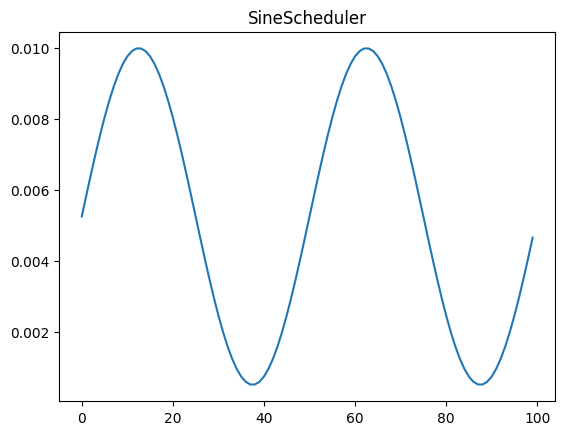

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [86]:
import torch
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

# Create an optimizer
initial_lr = 0.01
min_lr = 0.0005
optimizer = torch.optim.SGD([torch.randn(1, requires_grad=True)], lr= initial_lr)

import math
import torch
from torch.optim.lr_scheduler import _LRScheduler

class WarmRestartScheduler(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, last_epoch=-1):
        self.T_0 = T_0
        self.T_i = T_0
        self.T_mult = T_mult
        self.eta_max = eta_max
        super(WarmRestartScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch > self.T_i:
            self.last_epoch = 0
            self.T_i *= self.T_mult
        return [self.eta_max * (self.last_epoch / self.T_i) for base_lr in self.base_lrs]

    def _reset(self):
        return WarmRestartScheduler(self.optimizer, self.T_0, self.T_mult, self.eta_max)


class SineScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_min=0.01, eta_max=0.1, last_epoch=-1):
        self.T_0 = T_0
        self.T_mult = T_mult
        self.eta_min = eta_min
        self.eta_max = eta_max
        super(SineScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.eta_min + (self.eta_max - self.eta_min) * (1 + math.sin(2 * math.pi * self.last_epoch / self.T_0)) / 2
                for base_lr in self.base_lrs]

# Define the number of epochs
num_epochs = 100
cycles = 4
# Learning rate schedulers
# cosineAnnealingWarmRestarts = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=int(c.num_epochs/cycles), T_mult=1, eta_min=min_lr)
schedulers = {
    # "LambdaLR": lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch),
    # "MultiplicativeLR": lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95),
    # "StepLR": lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1),
    # "MultiStepLR": lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1),
    # "ConstantLR": lr_scheduler.ConstantLR(optimizer),
    # "LinearLR" : lr_scheduler.LinearLR(optimizer),
    # "ExponentialLR": lr_scheduler.ExponentialLR(optimizer, gamma=0.1),
    # "PolynomialLR": lr_scheduler.PolynomialLR(optimizer,total_iters=4, power=1.0),
    # "CosineAnnealingLR": lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0),
    # "ChainedScheduler" : lr_scheduler.ChainedScheduler([lr_scheduler.ConstantLR(optimizer, total_iters=10), cosineAnnealingWarmRestarts]),
    # "SequentialLR": lr_scheduler.SequentialLR(optimizer, schedulers=[lr_scheduler.ConstantLR(optimizer, factor=0.1, total_iters=2), lr_scheduler.ExponentialLR(optimizer, gamma=0.9)], milestones=[2]),
    # "ReduceLROnPlateau": lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
    # "CyclicLR": lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=1, step_size_up=5, mode='triangular2'),
    # "OneCycleLR": lr_scheduler.OneCycleLR(optimizer, max_lr=1, total_steps=num_epochs),
    # "CosineAnnealingWarmRestarts": lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=int(num_epochs/cycles), T_mult=1, eta_min=min_lr),
    # "WarmRestartScheduler" : WarmRestartScheduler(optimizer, T_0=int(num_epochs/cycles), T_mult=1, eta_max=initial_lr),
    "SineScheduler" : SineScheduler(optimizer, T_0=int(num_epochs/2), T_mult=1, eta_max=initial_lr, eta_min=min_lr, last_epoch=-1)
}


# Create a plot for each scheduler
for name, scheduler in schedulers.items():
    lrs = []
    for epoch in range(num_epochs):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        if name != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(epoch)  # Assume loss is decreasing with epoch for this example
        optimizer.zero_grad()

    plt.figure()
    plt.plot(lrs)
    plt.title(name)

plt.show()
